# Melanoma Detection

This is an attempt to differentiate between three types of skin lesions, melanoma, nevi and seborrheic keratosesone. Melanoma is cancerous; the other three are benign.

The data and objective are from the [ISIC 2017: Skin Lesion Analysis Towards Melanoma Detection](https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a)


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate
from functools import partial

In [4]:
np.random.seed(303)

## Load and view data

In [5]:
datapath = Path('../data').resolve() # absolute path to data
!ls $datapath

HAM10000_images_part_1.zip  hmnist_28_28_L.csv	  hmnist_8_8_RGB.csv
HAM10000_images_part_2.zip  hmnist_28_28_RGB.csv  images
HAM10000_metadata.csv	    hmnist_8_8_L.csv	  images_orig


In [7]:
tfms = get_transforms(flip_vert=True) # (flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [14]:
getbunch = partial(
    ImageDataBunch.from_csv,
    datapath,
    folder='images', 
    csv_labels='HAM10000_metadata.csv',
    valid_pct=0.2,
    fn_col=1, 
    label_col=2, 
    suffix='.jpg',
    ds_tfms=tfms,
    bs=64,
    size=128
)

In [23]:
data = getbunch(size=256).normalize(imagenet_stats)

In [24]:
data.classes

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

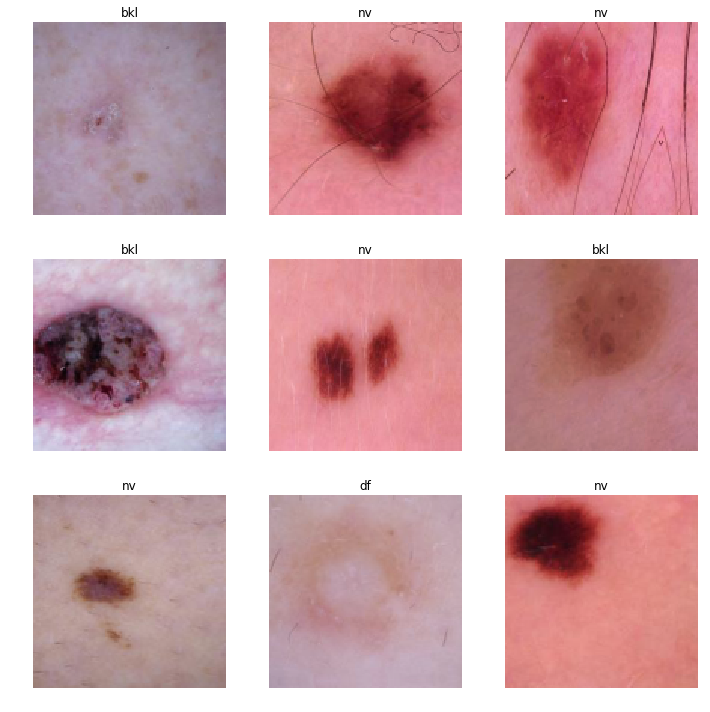

In [18]:
data.show_batch(rows=3, figsize=(10, 10))

In [75]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


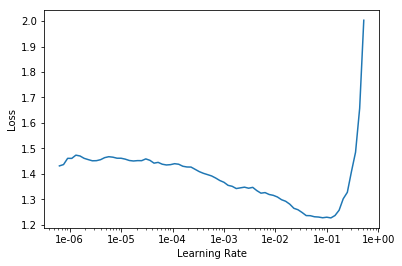

In [76]:
learn.lr_find()
learn.recorder.plot()

In [77]:
lr = 2e-3

In [78]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,error_rate
1,1.303437,0.845430,0.380000
2,1.050174,0.889691,0.366667
3,0.855209,0.707310,0.280000
4,0.718351,0.674894,0.286667
5,0.644995,0.669387,0.293333


In [79]:
learn.save('r50-128-frozen')

In [67]:
# _ = learn.load('r50-128-frozen')

In [80]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


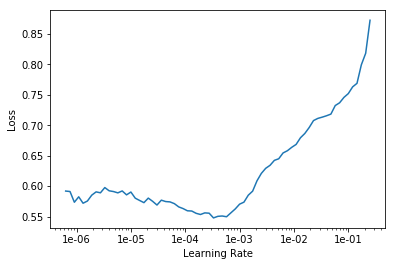

In [81]:
learn.lr_find()
learn.recorder.plot()

In [82]:
learn.fit_one_cycle(5, slice(2e-5, lr / 5))

epoch,train_loss,valid_loss,error_rate
1,0.536663,0.670178,0.273333
2,0.550126,0.650383,0.220000
3,0.504308,0.619169,0.220000
4,0.455997,0.600810,0.226667
5,0.411247,0.593976,0.200000


In [83]:
learn.save('r50-128-unfrozen')

In [95]:
_ = learn.load('r50-128-unfrozen')

In [96]:
data = get_bunch(size=256).normalize(imagenet_stats)

In [97]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


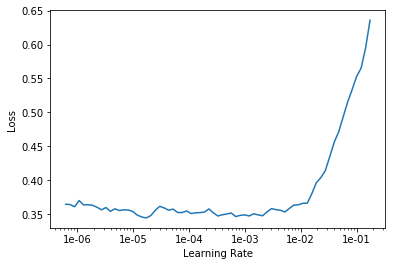

In [93]:
learn.lr_find()
learn.recorder.plot()

In [98]:
lr2 = 1e-4

In [99]:
learn.fit_one_cycle(5, lr2)

epoch,train_loss,valid_loss,error_rate
1,0.341418,0.580074,0.200000
2,0.357798,0.573807,0.206667
3,0.342985,0.575369,0.220000
4,0.343551,0.582841,0.213333
5,0.334939,0.573911,0.206667


In [100]:
learn.save('r50-256-frozen')

In [101]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


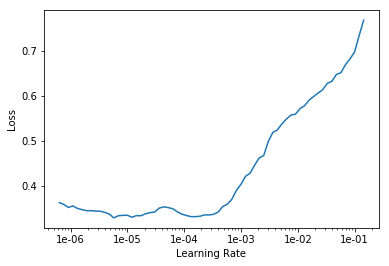

In [102]:
learn.lr_find()
learn.recorder.plot()

In [103]:
learn.fit_one_cycle(5, slice(2e-6, lr / 5))

epoch,train_loss,valid_loss,error_rate
1,0.351517,0.601655,0.206667
2,0.342574,0.636894,0.226667
3,0.331377,0.599180,0.226667
4,0.302377,0.618310,0.213333
5,0.269161,0.609172,0.206667


In [105]:
learn.save('r50-256-unfrozen')

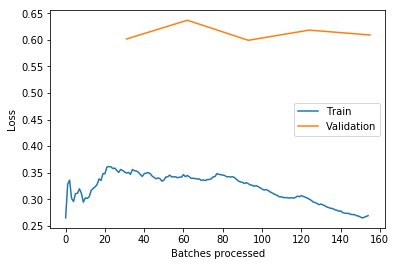

In [104]:
learn.recorder.plot_losses()